# MLflow Introduction: From Chaos to Control
# A Practical Guide to ML Operations

LEARNING OBJECTIVES

By the end of this notebook, you will:
1. Understand the challenges of traditional ML workflows without MLOps
2. Learn how to track experiments, parameters, and metrics with MLflow
3. Compare model performance systematically
4. Understand the value proposition of MLOps tooling


# SETUP: Installing Dependencies

In [ ]:
# print("📦 Installing required packages...")
# print("=" * 80)

# !pip install -q mlflow pandas numpy scikit-learn matplotlib seaborn

# print("✅ Installation complete!\n")

📦 Installing required packages...
✅ Installation complete!




[notice] A new release of pip is available: 23.3.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# PART 1: TRADITIONAL ML WORKFLOW (WITHOUT MLOPS)

Imagine you're a data scientist at a manufacturing company. Your task is to
predict equipment failure based on sensor data. You'll build several models,
tune parameters, and try to remember what worked best.

Sound familiar? Let's see what goes wrong...

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

STEP 1: Load Real Industrial Dataset

In [2]:
print("\n📊 Loading Real-World Dataset: Predictive Maintenance")
print("-" * 80)

# We'll use the AI4I 2020 Predictive Maintenance Dataset
# This is a synthetic dataset that reflects real predictive maintenance scenarios

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv"
try:
    # First, try the straightforward approach
    df = pd.read_csv(url)
    print(f"✅ Dataset loaded successfully from UCI Machine Learning Repository!")
except Exception as e:
    # Common failure: SSL certificate verification error in some environments
    print(f"⚠️ Failed to load via pandas.read_csv due to: {e}")
    print("Attempting a fallback download using requests with certificate verification disabled...")
    import requests, io, warnings
    # Suppress the InsecureRequestWarning while using verify=False
    warnings.filterwarnings('ignore', message='Unverified HTTPS request')
    try:
        resp = requests.get(url, verify=False, timeout=30)
        resp.raise_for_status()
        df = pd.read_csv(io.StringIO(resp.text))
        # Cache to local file for offline reuse
        local_path = 'ai4i2020.csv'
        with open(local_path, 'w', encoding='utf-8') as f:
            f.write(resp.text)
        print(f"✅ Dataset downloaded and cached to '{local_path}'")
    except Exception as e2:
        print(f"❌ Fallback download failed: {e2}")
        raise RuntimeError("Failed to download dataset. Please check network/SSL settings or manually download the file and place it as 'ai4i2020.csv' in the current directory.") from e2

print(f"   Shape: {df.shape[0]} rows × {df.shape[1]} columns")


📊 Loading Real-World Dataset: Predictive Maintenance
--------------------------------------------------------------------------------
✅ Dataset loaded successfully from UCI Machine Learning Repository!
   Shape: 10000 rows × 14 columns


In [3]:
print("\n🔍 Dataset Overview:")
df.head()


🔍 Dataset Overview:


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
print("\n📈 Dataset Statistics:")
df.describe()


📈 Dataset Statistics:


,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [5]:
# Check target distribution
# The AI4I dataset uses 'Machine failure' as the target column
target_col = 'Machine failure'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in dataset")

In [6]:
print(f"\n🎯 Target Distribution ('{target_col}'):")
print(df[target_col].value_counts())
failure_rate = df[target_col].mean()*100
print(f"   Failure Rate: {failure_rate:.2f}%")


🎯 Target Distribution ('Machine failure'):
Machine failure
0    9661
1     339
Name: count, dtype: int64
   Failure Rate: 3.39%



⚠️  IMPORTANT: This is an imbalanced dataset!
   With only 3.39% failures, we need to be careful about:
   - Choosing appropriate metrics (precision, recall, F1 > accuracy)
   - Stratified splitting to maintain class balance
   - Considering class weights or resampling techniques


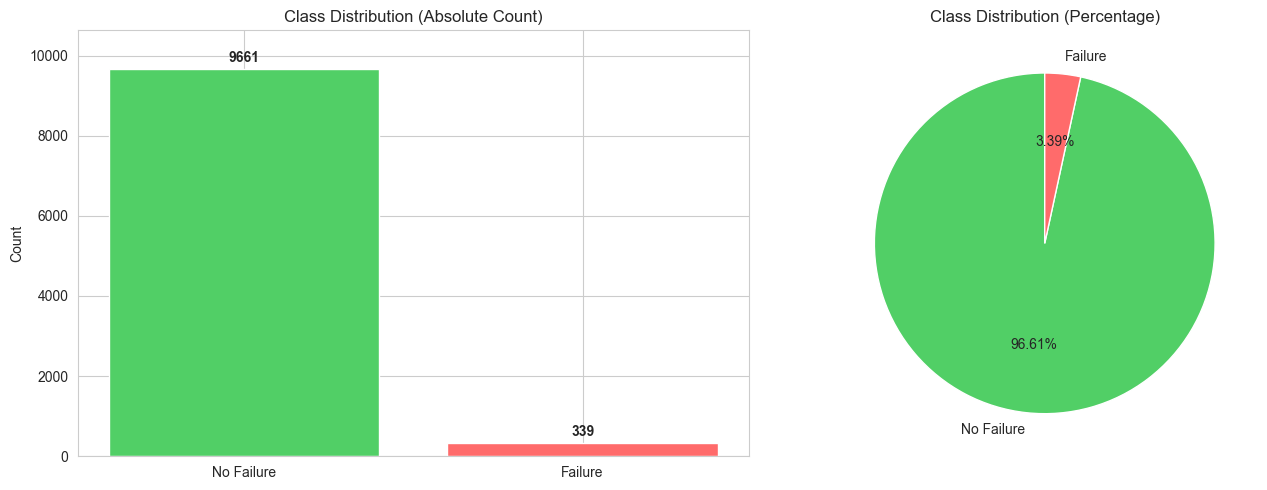


💡 Why this matters:
   In real predictive maintenance, failures are rare (which is good!)
   But this makes it challenging for ML models to learn the failure pattern.
   A naive model predicting 'no failure' every time would be 96.61% accurate!
   That's why we focus on F1-score, precision, and recall instead.


In [7]:
if failure_rate < 10:
    print(f"\n⚠️  IMPORTANT: This is an imbalanced dataset!")
    print(f"   With only {failure_rate:.2f}% failures, we need to be careful about:")
    print(f"   - Choosing appropriate metrics (precision, recall, F1 > accuracy)")
    print(f"   - Stratified splitting to maintain class balance")
    print(f"   - Considering class weights or resampling techniques")

# Visualize the imbalance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
counts = df[target_col].value_counts()
axes[0].bar(['No Failure', 'Failure'], counts.values, color=['#51cf66', '#ff6b6b'])
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution (Absolute Count)')
axes[0].set_ylim(0, max(counts.values) * 1.1)
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = ['#51cf66', '#ff6b6b']
axes[1].pie(counts.values, labels=['No Failure', 'Failure'], autopct='%1.2f%%',
            colors=colors, startangle=90)
axes[1].set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

print("\n💡 Why this matters:")
print("   In real predictive maintenance, failures are rare (which is good!)")
print("   But this makes it challenging for ML models to learn the failure pattern.")
print("   A naive model predicting 'no failure' every time would be 96.61% accurate!")
print("   That's why we focus on F1-score, precision, and recall instead.")


STEP 2: Data Preprocessing

In [8]:
print("\n🔧 Preprocessing Data...")
print("-" * 80)

# Select numeric features only (exclude ID columns and target)
# Common ID columns in AI4I dataset: UDI, Product ID
id_columns = ['UDI', 'Product ID', 'Product_ID', 'UID', 'Product_id']
columns_to_exclude = id_columns + [target_col]

# Also exclude the individual failure mode columns if they exist
failure_modes = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
columns_to_exclude.extend(failure_modes)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in columns_to_exclude]
# Handle the 'Type' column if it exists (categorical: L, M, H)
if 'Type' in df.columns and 'Type' not in numeric_cols:
    # One-hot encode the Type column
    type_dummies = pd.get_dummies(df['Type'], prefix='Type')
    X = pd.concat([df[numeric_cols], type_dummies], axis=1)
    print(f"✅ Encoded categorical 'Type' column")
else:
    X = df[numeric_cols]

y = df[target_col]

print(f"Features selected: {list(X.columns)}")
print(f"Target variable: {target_col}")


🔧 Preprocessing Data...
--------------------------------------------------------------------------------
✅ Encoded categorical 'Type' column
Features selected: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type_H', 'Type_L', 'Type_M']
Target variable: Machine failure


In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✂️ Data Split (Stratified to maintain class balance):")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   - Failures: {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"   Test set: {X_test.shape[0]} samples")
print(f"   - Failures: {y_test.sum()} ({y_test.mean()*100:.2f}%)")


✂️ Data Split (Stratified to maintain class balance):
   Training set: 8000 samples
   - Failures: 271 (3.39%)
   Test set: 2000 samples
   - Failures: 68 (3.40%)


In [10]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Features scaled using StandardScaler")

✅ Features scaled using StandardScaler


STEP 3: The Traditional Approach - Building Models Without Tracking

Now watch what happens when we build multiple models without proper tracking.
We'll train 3 different models, but keeping track of everything manually...

In [11]:
# We'll store results in a dictionary (the old-fashioned way)
manual_results = {}

*Model 1: Logistic Regression*

In [12]:
print("\n🔄 Training Model 1: Logistic Regression")
print("-" * 80)

start_time = datetime.now()

# Model parameters (we have to remember these!)
lr_params = {
    'C': 1.0,
    'max_iter': 1000,  # Increased for convergence
    'solver': 'lbfgs',
    'class_weight': 'balanced'  # Handle imbalanced data
}

print(f"Parameters: {lr_params}")
print(f"💡 Note: Using 'class_weight=balanced' for imbalanced dataset")

lr_model = LogisticRegression(**lr_params, random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics (manually!)
lr_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr, zero_division=0),
    'recall': recall_score(y_test, y_pred_lr, zero_division=0),
    'f1': f1_score(y_test, y_pred_lr, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_lr)
}

training_time = (datetime.now() - start_time).total_seconds()

print(f"✅ Training completed in {training_time:.2f} seconds")
print(f"   Accuracy: {lr_metrics['accuracy']:.4f}")
print(f"   F1-Score: {lr_metrics['f1']:.4f}")

# Store results (manually tracking everything!)
manual_results['logistic_regression'] = {
    'params': lr_params,
    'metrics': lr_metrics,
    'training_time': training_time,
    'model': lr_model
}



🔄 Training Model 1: Logistic Regression
--------------------------------------------------------------------------------
Parameters: {'C': 1.0, 'max_iter': 1000, 'solver': 'lbfgs', 'class_weight': 'balanced'}
💡 Note: Using 'class_weight=balanced' for imbalanced dataset
✅ Training completed in 0.03 seconds
   Accuracy: 0.8250
   F1-Score: 0.2424


*Model 2: Random Forest*

In [13]:
print("\n🔄 Training Model 2: Random Forest")
print("-" * 80)

start_time = datetime.now()

rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 2,
    'random_state': 42,
    'class_weight': 'balanced'  # Handle imbalanced data
}

print(f"Parameters: {rf_params}")
print(f"💡 Note: Using 'class_weight=balanced' for imbalanced dataset")

rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

rf_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf, zero_division=0),
    'recall': recall_score(y_test, y_pred_rf, zero_division=0),
    'f1': f1_score(y_test, y_pred_rf, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_rf)
}

training_time = (datetime.now() - start_time).total_seconds()

print(f"✅ Training completed in {training_time:.2f} seconds")
print(f"   Accuracy: {rf_metrics['accuracy']:.4f}")
print(f"   F1-Score: {rf_metrics['f1']:.4f}")

manual_results['random_forest'] = {
    'params': rf_params,
    'metrics': rf_metrics,
    'training_time': training_time,
    'model': rf_model
}


🔄 Training Model 2: Random Forest
--------------------------------------------------------------------------------
Parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'random_state': 42, 'class_weight': 'balanced'}
💡 Note: Using 'class_weight=balanced' for imbalanced dataset
✅ Training completed in 0.29 seconds
   Accuracy: 0.9760
   F1-Score: 0.6308


😵 Problem: Code duplication everywhere! And we're writing to different notebooks!


*Model 3: Gradient Boosting*

In [14]:
print("\n🔄 Training Model 3: Gradient Boosting")
print("-" * 80)

start_time = datetime.now()

gb_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 5,
    'random_state': 42
}

print(f"Parameters: {gb_params}")

gb_model = GradientBoostingClassifier(**gb_params)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_proba_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

gb_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_gb),
    'precision': precision_score(y_test, y_pred_gb, zero_division=0),
    'recall': recall_score(y_test, y_pred_gb, zero_division=0),
    'f1': f1_score(y_test, y_pred_gb, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_gb)
}

training_time = (datetime.now() - start_time).total_seconds()

print(f"✅ Training completed in {training_time:.2f} seconds")
print(f"   Accuracy: {gb_metrics['accuracy']:.4f}")
print(f"   F1-Score: {gb_metrics['f1']:.4f}")

manual_results['gradient_boosting'] = {
    'params': gb_params,
    'metrics': gb_metrics,
    'training_time': training_time,
    'model': gb_model
}


🔄 Training Model 3: Gradient Boosting
--------------------------------------------------------------------------------
Parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 42}
✅ Training completed in 0.76 seconds
   Accuracy: 0.9850
   F1-Score: 0.7581


😱 Problem: Which model was best? Which parameters? When did we train it?

STEP 4: Manual Comparison (The Pain Point)


😫 THE STRUGGLE: Manually Comparing Results

Now we need to compare our models. Let's create a comparison table manually...
This is tedious and error-prone!


📊 Manual Results Comparison:
              Model  accuracy  precision   recall       f1  roc_auc  Training_Time
logistic_regression     0.825   0.142132 0.823529 0.242424 0.906946       0.028016
      random_forest     0.976   0.661290 0.602941 0.630769 0.956742       0.292700
  gradient_boosting     0.985   0.839286 0.691176 0.758065 0.969073       0.761503


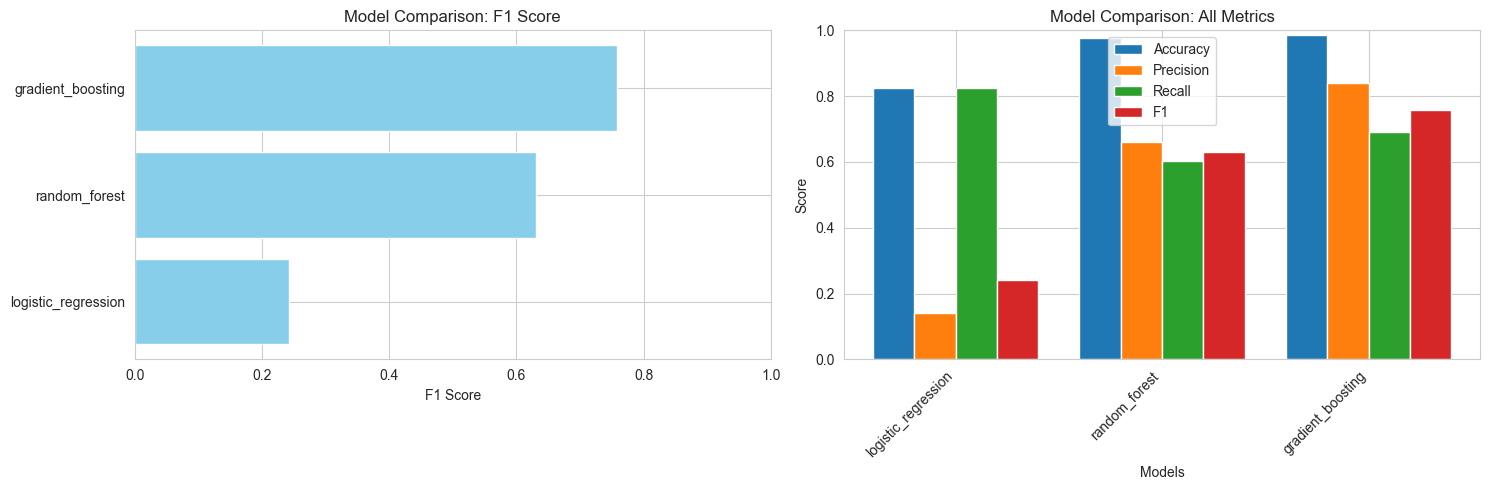


⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ 
PROBLEMS WITH THIS APPROACH:
⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️ 

1. 📝 No automatic tracking - We had to manually save everything
2. 🔍 Hard to reproduce - Which exact parameters did we use 2 weeks ago?
3. 📊 No centralized comparison - Results scattered across notebooks
4. 🤝 No collaboration - How do teammates see our experiments?
5. 💾 No model versioning - Where is that good model from yesterday?
6. 📈 Manual visualization - We have to create plots from scratch each time
7. ⏰ No time tracking - When did we train this? How long did it take?
8. 🏷️ No metadata - What dataset version? What preprocessing steps?

Imagine doing this for 50+ experiments! 😱



In [15]:
print("\n" + "=" * 80)
print("😫 THE STRUGGLE: Manually Comparing Results")
print("=" * 80)
print("""
Now we need to compare our models. Let's create a comparison table manually...
This is tedious and error-prone!
""")

# Create comparison DataFrame
comparison_data = []
for model_name, results in manual_results.items():
    row = {'Model': model_name}
    row.update(results['metrics'])
    row['Training_Time'] = results['training_time']
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 Manual Results Comparison:")
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: F1 Score comparison
comparison_df_sorted = comparison_df.sort_values('f1', ascending=True)
axes[0].barh(comparison_df_sorted['Model'], comparison_df_sorted['f1'], color='skyblue')
axes[0].set_xlabel('F1 Score')
axes[0].set_title('Model Comparison: F1 Score')
axes[0].set_xlim(0, 1)

# Plot 2: Multiple metrics
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    axes[1].bar(x + i * width, comparison_df[metric], width, label=metric.capitalize())

axes[1].set_xlabel('Models')
axes[1].set_ylabel('Score')
axes[1].set_title('Model Comparison: All Metrics')
axes[1].set_xticks(x + width * 1.5)
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("\n" + "⚠️ " * 30)
print("PROBLEMS WITH THIS APPROACH:")
print("⚠️ " * 30)
print("""
1. 📝 No automatic tracking - We had to manually save everything
2. 🔍 Hard to reproduce - Which exact parameters did we use 2 weeks ago?
3. 📊 No centralized comparison - Results scattered across notebooks
4. 🤝 No collaboration - How do teammates see our experiments?
5. 💾 No model versioning - Where is that good model from yesterday?
6. 📈 Manual visualization - We have to create plots from scratch each time
7. ⏰ No time tracking - When did we train this? How long did it take?
8. 🏷️ No metadata - What dataset version? What preprocessing steps?

Imagine doing this for 50+ experiments! 😱
""")

# PART 2: INTRODUCING MLFLOW (THE SOLUTION)

MLflow is an open-source platform for managing the ML lifecycle.
It tracks experiments, packages code, and manages model deployment.

Let's see how it solves our problems!

In [16]:
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

STEP 5: MLflow Setup

In [17]:
# Set experiment name
experiment_name = "Predictive_Maintenance_Demo"
mlflow.set_experiment(experiment_name)

print(f"✅ MLflow experiment created: '{experiment_name}'")
print(f"📍 Tracking URI: {mlflow.get_tracking_uri()}")

/Users/eaedk_pro/Documents/GitHub/mlops/.venv/lib/python3.13/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/11/25 09:44:22 INFO mlflow.tracking.fluent: Experiment with name 'Predictive_Maintenance_Demo' does not exist. Creating a new experiment.


✅ MLflow experiment created: 'Predictive_Maintenance_Demo'
📍 Tracking URI: file:///Users/eaedk_pro/Documents/GitHub/mlops/jour1/mlruns


In [18]:
print("\n" + "=" * 80)
print("🎯 THE MAGIC: Training Models WITH MLflow Tracking")
print("=" * 80)
print("""
Watch how MLflow automatically tracks everything we need!
No more manual logging, no more forgotten parameters.

We'll demonstrate TWO approaches:
1. Manual logging (more control)
2. Autolog (automatic, less code)
""")


🎯 THE MAGIC: Training Models WITH MLflow Tracking

Watch how MLflow automatically tracks everything we need!
No more manual logging, no more forgotten parameters.

We'll demonstrate TWO approaches:
1. Manual logging (more control)
2. Autolog (automatic, less code)



STEP 6: Training Models WITH MLflow

Watch how MLflow automatically tracks everything we need!
No more manual logging, no more forgotten parameters.

APPROACH 1: Manual Logging (More Control)

In [19]:
def train_with_manual_logging(model, model_name, params, X_train, X_test, y_train, y_test):
    """
    Train a model with EXPLICIT MLflow logging.

    This demonstrates manual control over tracking.
    """

    print(f"\n{'='*80}")
    print(f"🚀 Training: {model_name} (Manual Logging)")
    print(f"{'='*80}")

    # Start an MLflow run
    with mlflow.start_run(run_name=model_name) as run:

        print(f"📊 Run ID: {run.info.run_id}")

        # 1. MANUALLY log parameters
        print("\n📝 Step 1: Logging parameters...")
        mlflow.log_params(params)
        print(f"   ✅ Logged: {list(params.keys())}")

        # 2. Train the model
        print("\n🏋️ Step 2: Training model...")
        start_time = datetime.now()
        model.fit(X_train, y_train)
        training_time = (datetime.now() - start_time).total_seconds()
        print(f"   ✅ Training completed in {training_time:.2f}s")

        # 3. Make predictions
        print("\n🎯 Step 3: Making predictions...")
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

        # 4. MANUALLY calculate and log metrics
        print("\n📊 Step 4: Calculating and logging metrics...")
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
        }

        if y_pred_proba is not None:
            metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba)

        # Log each metric individually
        for metric_name, value in metrics.items():
            mlflow.log_metric(metric_name, value)
            print(f"   ✅ {metric_name}: {value:.4f}")

        mlflow.log_metric('training_time_seconds', training_time)
        print(f"   ✅ training_time: {training_time:.2f}s")

        # 5. MANUALLY log the model
        print("\n💾 Step 5: Saving model artifact...")
        mlflow.sklearn.log_model(model, "model")
        print("   ✅ Model saved for deployment")

        # 6. MANUALLY add tags for organization
        print("\n🏷️ Step 6: Adding tags...")
        mlflow.set_tags({
            'model_type': model_name,
            'dataset': 'Predictive Maintenance',
            'framework': 'scikit-learn',
            'tracking_method': 'manual'
        })
        print("   ✅ Tags added for filtering")

        print(f"\n🎉 Run completed successfully!")
        print(f"💡 Everything was EXPLICITLY logged by us")

        return run.info.run_id, metrics


# Train Logistic Regression with Manual Logging
print("\n" + "-" * 80)
print("Training Model 1: Logistic Regression")
print("-" * 80)

lr_model_manual = LogisticRegression(**lr_params, random_state=42)
lr_run_id, lr_metrics = train_with_manual_logging(
    lr_model_manual,
    "Logistic_Regression_Manual",
    lr_params,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test
)

2025/11/25 09:44:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



--------------------------------------------------------------------------------
Training Model 1: Logistic Regression
--------------------------------------------------------------------------------

🚀 Training: Logistic_Regression_Manual (Manual Logging)
📊 Run ID: 53cce161789347c1a6a1c9c8029c07d6

📝 Step 1: Logging parameters...
   ✅ Logged: ['C', 'max_iter', 'solver', 'class_weight']

🏋️ Step 2: Training model...
   ✅ Training completed in 0.00s

🎯 Step 3: Making predictions...

📊 Step 4: Calculating and logging metrics...
   ✅ accuracy: 0.8250
   ✅ precision: 0.1421
   ✅ recall: 0.8235
   ✅ f1: 0.2424
   ✅ roc_auc: 0.9069
   ✅ training_time: 0.00s

💾 Step 5: Saving model artifact...


2025/11/25 09:44:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


   ✅ Model saved for deployment

🏷️ Step 6: Adding tags...
   ✅ Tags added for filtering

🎉 Run completed successfully!
💡 Everything was EXPLICITLY logged by us


APPROACH 2: Autolog (Minimal Code)

In [20]:
def train_with_autolog(model, model_name, params, X_train, X_test, y_train, y_test):
    """
    Train a model using MLflow's autolog feature.

    MLflow automatically captures everything!
    """

    print(f"\n{'='*80}")
    print(f"🤖 Training: {model_name} (Autolog)")
    print(f"{'='*80}")

    # CRITICAL: Disable any previous autolog and enable fresh
    mlflow.sklearn.autolog(disable=True)
    mlflow.sklearn.autolog(
        log_input_examples=False,  # Disable to avoid errors
        log_model_signatures=True,
        log_models=True,
        disable=False,
        exclusive=False,
        silent=False
    )

    # Start an MLflow run
    with mlflow.start_run(run_name=model_name) as run:

        print(f"📊 Run ID: {run.info.run_id}")
        print(f"🔮 Autolog ENABLED - MLflow is watching!\n")

        # Train the model - THAT'S IT! MLflow handles the rest
        print("🏋️ Training model (MLflow auto-capturing everything)...")
        start_time = datetime.now()
        model.fit(X_train, y_train)
        training_time = (datetime.now() - start_time).total_seconds()
        print(f"   ✅ Training completed in {training_time:.2f}s")

        # Make predictions for our own metrics display
        print("\n🎯 Making predictions...")
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

        # Calculate metrics for display (MLflow already logged training metrics)
        print("\n📊 Calculating test metrics...")
        metrics = {
            'test_accuracy': accuracy_score(y_test, y_pred),
            'test_precision': precision_score(y_test, y_pred, zero_division=0),
            'test_recall': recall_score(y_test, y_pred, zero_division=0),
            'test_f1': f1_score(y_test, y_pred, zero_division=0),
        }

        if y_pred_proba is not None:
            metrics['test_roc_auc'] = roc_auc_score(y_test, y_pred_proba)

        # Log our custom test metrics
        for metric_name, value in metrics.items():
            mlflow.log_metric(metric_name, value)
            print(f"   ✅ {metric_name}: {value:.4f}")

        mlflow.log_metric('training_time_seconds', training_time)
        print(f"   ✅ training_time: {training_time:.2f}s")

        # Add custom tags
        mlflow.set_tags({
            'model_type': model_name,
            'tracking_method': 'autolog'
        })

        print(f"\n🎉 Run completed!")
        print(f"💡 MLflow AUTO-LOGGED: parameters, training metrics, model")
        print(f"💡 We MANUALLY LOGGED: test metrics, training time, tags")

        return run.info.run_id, metrics


# Disable any previous autolog before starting
mlflow.sklearn.autolog(disable=True)

# Train Random Forest with Autolog
print("\n" + "-" * 80)
print("Training Model 2: Random Forest")
print("-" * 80)

rf_model_auto = RandomForestClassifier(**rf_params)
rf_run_id, rf_metrics = train_with_autolog(
    rf_model_auto,
    "Random_Forest_AutoLog",
    rf_params,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test
)

# Train Gradient Boosting with Autolog
print("\n" + "-" * 80)
print("Training Model 3: Gradient Boosting")
print("-" * 80)

gb_model_auto = GradientBoostingClassifier(**gb_params)
gb_run_id, gb_metrics = train_with_autolog(
    gb_model_auto,
    "Gradient_Boosting_AutoLog",
    gb_params,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test
)



--------------------------------------------------------------------------------
Training Model 2: Random Forest
--------------------------------------------------------------------------------

🤖 Training: Random_Forest_AutoLog (Autolog)


2025/11/25 09:46:09 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


📊 Run ID: edb0973607b545b8834d2fc211d1c40e
🔮 Autolog ENABLED - MLflow is watching!

🏋️ Training model (MLflow auto-capturing everything)...


2025/11/25 09:46:11 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


   ✅ Training completed in 2.01s

🎯 Making predictions...

📊 Calculating test metrics...
   ✅ test_accuracy: 0.9760
   ✅ test_precision: 0.6613
   ✅ test_recall: 0.6029
   ✅ test_f1: 0.6308
   ✅ test_roc_auc: 0.9567
   ✅ training_time: 2.01s

🎉 Run completed!
💡 MLflow AUTO-LOGGED: parameters, training metrics, model
💡 We MANUALLY LOGGED: test metrics, training time, tags

--------------------------------------------------------------------------------
Training Model 3: Gradient Boosting
--------------------------------------------------------------------------------

🤖 Training: Gradient_Boosting_AutoLog (Autolog)
📊 Run ID: a1b356e6b32b42df9cd79a071d8ace1c
🔮 Autolog ENABLED - MLflow is watching!

🏋️ Training model (MLflow auto-capturing everything)...
   ✅ Training completed in 2.16s

🎯 Making predictions...

📊 Calculating test metrics...
   ✅ test_accuracy: 0.9850
   ✅ test_precision: 0.8393
   ✅ test_recall: 0.6912
   ✅ test_f1: 0.7581
   ✅ test_roc_auc: 0.9691
   ✅ training_time: 2.

STEP 7: Querying and Comparing Results with MLflow

Now let's see how easy it is to retrieve and compare our experiments!
No manual tracking needed - MLflow remembers everything.


In [21]:
# Get all runs from this experiment
client = MlflowClient()
experiment = client.get_experiment_by_name(experiment_name)
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.test_f1 DESC"]  # Order by F1 score
)

print(f"\n📈 Found {len(runs)} runs in experiment '{experiment_name}'")
print("-" * 80)

# Create comparison DataFrame
mlflow_results = []
for run in runs:
    run_name = run.data.tags.get('mlflow.runName', 'Unknown')
    tracking_method = run.data.tags.get('tracking_method', 'unknown')

    mlflow_results.append({
        'Run_Name': run_name,
        'Method': tracking_method,
        'Test_Accuracy': run.data.metrics.get('test_accuracy', run.data.metrics.get('accuracy', 0)),
        'Test_Precision': run.data.metrics.get('test_precision', run.data.metrics.get('precision', 0)),
        'Test_Recall': run.data.metrics.get('test_recall', run.data.metrics.get('recall', 0)),
        'Test_F1': run.data.metrics.get('test_f1', run.data.metrics.get('f1', 0)),
        'Test_ROC_AUC': run.data.metrics.get('test_roc_auc', run.data.metrics.get('roc_auc', 0)),
        'Training_Time': run.data.metrics.get('training_time_seconds', 0),
        'Run_ID': run.info.run_id[:8] + '...'
    })

mlflow_df = pd.DataFrame(mlflow_results)

print("\n✨ RESULTS COMPARISON (Automatically Retrieved from MLflow):")
print("=" * 80)
print(mlflow_df.to_string(index=False))



📈 Found 3 runs in experiment 'Predictive_Maintenance_Demo'
--------------------------------------------------------------------------------

✨ RESULTS COMPARISON (Automatically Retrieved from MLflow):
                  Run_Name  Method  Test_Accuracy  Test_Precision  Test_Recall  Test_F1  Test_ROC_AUC  Training_Time      Run_ID
 Gradient_Boosting_AutoLog autolog          0.985        0.839286     0.691176 0.758065      0.969073       2.155718 a1b356e6...
     Random_Forest_AutoLog autolog          0.976        0.661290     0.602941 0.630769      0.956742       2.013613 edb09736...
Logistic_Regression_Manual  manual          0.825        0.142132     0.823529 0.242424      0.906946       0.004267 53cce161...


STEP 8: Identifying the Best Model

Now that we've trained multiple models, let's see how MLflow helps us:
1. Register models for production use
2. Version models automatically
3. Transition models through stages (Staging → Production)
4. Load and use models easily

In [22]:

# Get all runs and find the best one based on F1 score
client = MlflowClient()
experiment = client.get_experiment_by_name(experiment_name)

runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.test_f1 DESC"], # Order by F1 score
    max_results=5
)

print(f"\n📊 Top 5 Models by F1 Score:")
print("-" * 80)

best_runs = []
for i, run in enumerate(runs, 1):
    run_name = run.data.tags.get('mlflow.runName', 'Unknown')
    # Use .get with a default value of 0 in case the metric is missing for a run
    f1_score = run.data.metrics.get('test_f1', run.data.metrics.get('f1', 0))
    accuracy = run.data.metrics.get('test_accuracy', run.data.metrics.get('accuracy', 0))
    roc_auc = run.data.metrics.get('test_roc_auc', run.data.metrics.get('roc_auc', 0))

    print(f"{i}. {run_name}")
    print(f"   Run ID: {run.info.run_id}")
    print(f"   F1 Score: {f1_score:.4f}")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   ROC-AUC: {roc_auc:.4f}")
    print()

    best_runs.append({
        'run_id': run.info.run_id,
        'run_name': run_name,
        'f1_score': f1_score
    })

# Get the absolute best model
if best_runs: # Check if the list is not empty
    best_run_id = best_runs[0]['run_id']
    best_run_name = best_runs[0]['run_name']
    best_f1 = best_runs[0]['f1_score']

    print(f"🥇 BEST MODEL: {best_run_name}")
    print(f"   Run ID: {best_run_id}")
    print(f"   F1 Score: {best_f1:.4f}")
else:
    print("⚠️ No runs found with 'test_f1' metric in the current experiment to determine the best model.")
    print("   Please ensure training runs completed successfully and logged metrics.")



📊 Top 5 Models by F1 Score:
--------------------------------------------------------------------------------
1. Gradient_Boosting_AutoLog
   Run ID: a1b356e6b32b42df9cd79a071d8ace1c
   F1 Score: 0.7581
   Accuracy: 0.9850
   ROC-AUC: 0.9691

2. Random_Forest_AutoLog
   Run ID: edb0973607b545b8834d2fc211d1c40e
   F1 Score: 0.6308
   Accuracy: 0.9760
   ROC-AUC: 0.9567

3. Logistic_Regression_Manual
   Run ID: 53cce161789347c1a6a1c9c8029c07d6
   F1 Score: 0.2424
   Accuracy: 0.8250
   ROC-AUC: 0.9069

🥇 BEST MODEL: Gradient_Boosting_AutoLog
   Run ID: a1b356e6b32b42df9cd79a071d8ace1c
   F1 Score: 0.7581


In [ ]:
!mlflow ui --host 127.0.0.1 --port 5000

/Users/eaedk_pro/Documents/GitHub/mlops/.venv/lib/python3.13/site-packages/mlflow/server/handlers.py:256: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, artifact_uri)
/Users/eaedk_pro/Documents/GitHub/mlops/.venv/lib/python3.13/site-packages/mlflow/server/handlers.py:285: FutureWarning: Filesystem model registry backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri)
[MLflow] Security middleware enabled with default settings (localhost-only). To allow connections from other hosts, use --host 0.0.0.0 and configure --allowed-hosts and --cors-allowed-origins.
INFO:     Uvicorn running on http://127.0.0.1:5000 (Press CTRL+C to quit)
INFO:     Started paren